In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

In [3]:
#weird workaround for multiple copies of OpenMP (linked to importing pytorch)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [4]:
import roicat

This notebook is for visualization of the results of an ROICaT run. You can play with different inclusion criteria here, and also combine classification and tracking results to view the intersection of the two.

In [17]:
from pathlib import Path

use_classificationResults = False
subject = 'SP061'
fov_name = 'FOV_05'

#dir_save = Path('G:/Shared drives/WG-Mesoscope/Chronic/'+subject).resolve()
dir_save = Path('Y:/Subjects/'+subject+'/Chronic').resolve()

name_save = fov_name

results = roicat.helpers.pickle_load(
    filepath=str(dir_save / (name_save + '.ROICaT.tracking.results' + '.pkl')),
    zipCompressed=False,
)

rundata = roicat.helpers.pickle_load(
    filepath=str(dir_save / (name_save + '.ROICaT.tracking.rundata' + '.pkl')),
    zipCompressed=False,
)

if use_classificationResults:
    results_classification = roicat.helpers.pickle_load(
        filepath=str(dir_save / (name_save + '.ROICaT.classification_drawn.results' + '.pkl')),
    )
else:
    results_classification = None

In [18]:
#print(len(np.unique(results_full['clusters']['labels'])))
print(len(np.unique(results['clusters']['labels'])))
#print(len(np.unique(results2['clusters']['labels'])))

7422


In [19]:
#roicat.helpers.matlab_save(
#    obj=results,
#    filepath=dir_save / (fov_name + '.ROICaT.tracking.results.mat'),
#)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_10572\342176109.py:48: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')


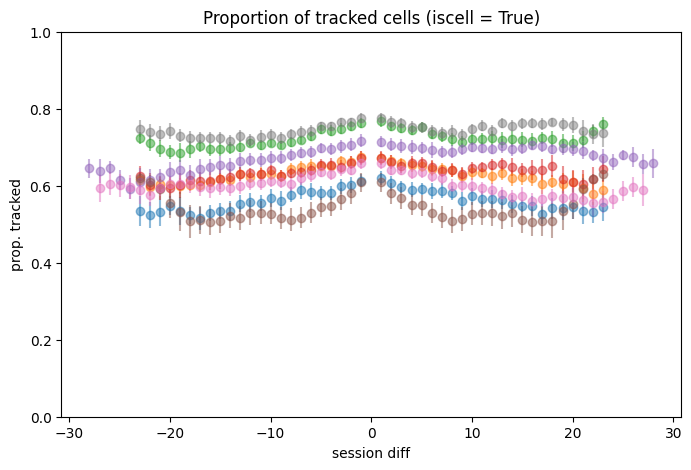

In [22]:
#plot showing the average proportion of clusters shared before and after on a given day (only for ROIs with iscell=True) across group of FOVs
import scipy.stats as st
from pathlib import Path

suff = '_iscell'

#fov_names = ['FOV_00all','FOV_01all','FOV_02all','FOV_03all','FOV_04all','FOV_05all','FOV_06all','FOV_07all']
#fov_names = ['FOV_00all','FOV_01all']
subject = 'SP058'; fov_names = ['00','01','02','03','04','05','06','07'] #for SP058
#subject = 'SP061'; fov_names = ['00','01','02','03','04','05','06','07'] #for SP061
#subject = 'SP061'; fov_names = ['01','02','03','05','06','07'] #for SP061

#dir_save = Path('G:/Shared drives/WG-Mesoscope/Chronic/'+subject).resolve()
dir_save = Path('Y:/Subjects/'+subject+'/Chronic').resolve()

fig, ax = plt.subplots(figsize=(8,5))

for ii,fov_id in enumerate(fov_names):

    fov_name = 'FOV_'+fov_id
    results = roicat.helpers.pickle_load(
        filepath=str(dir_save / (fov_name + '.ROICaT.tracking.results' + '.pkl')),
        zipCompressed=False,
    )
    
    paths_allStat = results['input_data']['paths_stat']
    paths_allIscell = list(np.unique([(Path(path) / '..' / 'iscell.npy').resolve() for path in paths_allStat]))
    iscell_byS = [np.load(path)[:,0] for path in paths_allIscell]
    iscell_all = np.concatenate(iscell_byS)

    ucids = np.array(results['clusters']['labels'])
    lbS = results['clusters']['labels_bySession']
    
    propShared_aroundSess = np.empty((len(lbS),2*len(lbS)-1))
    propShared_aroundSess[:] = np.nan
    iMid = len(lbS)-1
    
    for i, labs in enumerate(lbS):
        #ucids_thisSession = labs[np.isin(labs,np.unique(ucids[ucids>=0])) * np.array(iscell_byS[i],dtype='bool')]
        ucids_thisSession = np.array(labs)[np.array(iscell_byS[i],dtype='bool')]
        vals = np.array([np.sum(np.isin(l,ucids_thisSession[ucids_thisSession>=0])) for l in lbS])/len(ucids_thisSession)
        vals[i] = 1 #make sure ref value is 1
        propShared_aroundSess[i,len(lbS)-i-1+np.arange(len(lbS))] = vals
    
    data = propShared_aroundSess
    x = np.arange(-len(lbS)+1,len(lbS))
    y = np.nanmean(propShared_aroundSess,axis=0)
    err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')
    #[l,u] = st.t.interval(0.90, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    cutoff = 5

    idx0 = x==0
    x = np.delete(x, idx0)
    y = np.delete(y, idx0)
    err = np.delete(err, idx0)
    
    ax.errorbar(x[cutoff:-cutoff], y[cutoff:-cutoff], yerr=err[cutoff:-cutoff], fmt='o', alpha=0.5)
    

ax.set_ylim([0,1])
ax.set_xlabel('session diff')
ax.set_ylabel('prop. tracked')
ax.set_title("Proportion of tracked cells (iscell = True)")
#plt.legend(fov_names,fontsize='small')

plt.show()
fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_propCells_tracked' + suff + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_propCells_tracked' + suff + '.png'),bbox_inches='tight')

In [23]:
all_datesSess = []
for ii,fov_id in enumerate(fov_names):
    fov_name = 'FOV_'+fov_id
    results = roicat.helpers.pickle_load(
        filepath=str(dir_save / (fov_name + '.ROICaT.tracking.results' + '.pkl')),
        zipCompressed=False,
    )
    all_datesSess += [os.path.join(Path(p).parents[4].name, Path(p).parents[3].name)  for p in results['input_data']['paths_stat']]
    
each_dateSess = np.unique(all_datesSess)

x = np.arange(len(each_dateSess))

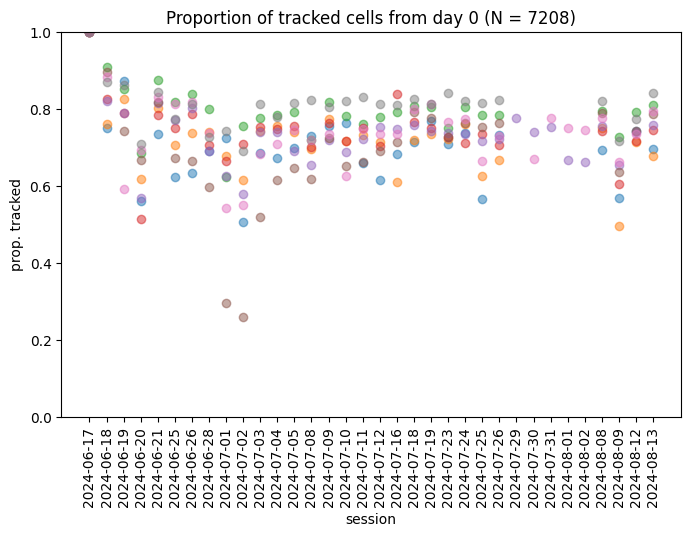

In [24]:
#plot showing the average proportion of clusters shared before and after on a given day (only for ROIs with iscell=True) across group of FOVs
import scipy.stats as st
from pathlib import Path

suff = '_iscell' #for saving
i_refSess = 0 #which session to track cells from

#subject = 'SP058'
#fov_names = ['FOV_00all','FOV_01all','FOV_02all','FOV_03all','FOV_04all','FOV_05all','FOV_06all','FOV_07all']
#fov_names = ['FOV_00all','FOV_01all']
#fov_names = ['04','00','01','02','03','05','06','07']
#dir_save = Path('G:/Shared drives/WG-Mesoscope/Chronic/'+subject).resolve()

fig, ax = plt.subplots(figsize=(8,5))
#fig, ax = plt.subplots(figsize=(12,5))

n_refSession = 0

for ii,fov_id in enumerate(fov_names):

    fov_name = 'FOV_'+fov_id
    results = roicat.helpers.pickle_load(
        filepath=str(dir_save / (fov_name + '.ROICaT.tracking.results' + '.pkl')),
        zipCompressed=False,
    )
    
    paths_allStat = results['input_data']['paths_stat']
    paths_allIscell = list(np.unique([(Path(path) / '..' / 'iscell.npy').resolve() for path in paths_allStat]))
    iscell_byS = [np.load(path)[:,0] for path in paths_allIscell]
    
    lbS = results['clusters']['labels_bySession']
    
    datesSess = [os.path.join(Path(p).parents[4].name, Path(p).parents[3].name)  for p in paths_allStat]

    propShared = np.empty((len(each_dateSess),))
    propShared[:] = np.nan
    
    ucids_refSession = np.array(lbS[i_refSess])[np.array(iscell_byS[i_refSess],dtype='bool')]
    ucids_refSession_clusters = ucids_refSession[ucids_refSession>=0]
    
    props = np.array([np.sum(np.isin(l,ucids_refSession_clusters)) for l in lbS])/len(ucids_refSession_clusters)
    propShared[np.isin(each_dateSess,datesSess)] = props
    #propShared[0] = np.nan

    n_refSession += len(ucids_refSession_clusters)
    
    ax.plot(x, propShared, 'o', alpha=0.5)
    

ax.set_xticks(x, [d[:10] for d in each_dateSess], rotation='vertical')
ax.set_ylim([0,1])
ax.set_xlabel('session')
ax.set_ylabel('prop. tracked')
ax.set_title("Proportion of tracked cells from day " + str(i_refSess) + " (N = " + str(n_refSession) +")")


#plt.legend(fov_names,fontsize='small')

plt.show()
fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_propCells_tracked' + suff + '_d' + str(i_refSess) + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_propCells_tracked' + suff + '_d' + str(i_refSess) + '.png'),bbox_inches='tight')

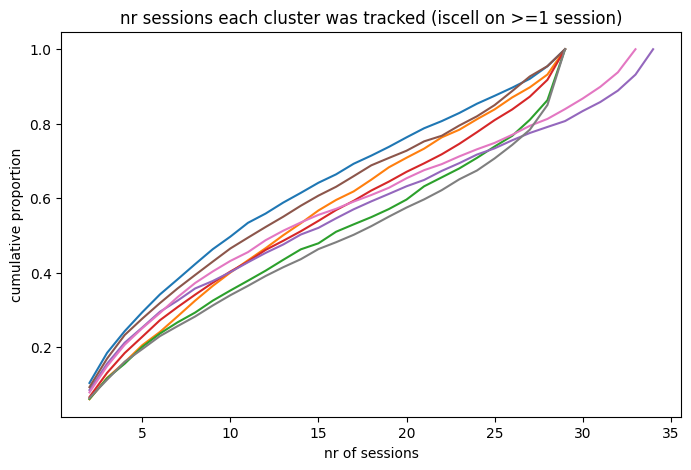

In [25]:
fig, ax = plt.subplots(figsize=(8,5))

for ii,fov_id in enumerate(fov_names):

    fov_name = 'FOV_'+fov_id
    results = roicat.helpers.pickle_load(
        filepath=str(dir_save / (fov_name + '.ROICaT.tracking.results' + '.pkl')),
        zipCompressed=False,
    )

    #load iscell arrays
    paths_allStat = results['input_data']['paths_stat']
    paths_allIscell = list(np.unique([(Path(path) / '..' / 'iscell.npy').resolve() for path in paths_allStat]))
    iscell_byS = [np.load(path)[:,0] for path in paths_allIscell]
    iscell_all = np.concatenate(iscell_byS)

    #find unique cluster labels for which iscell=True (on at least one day)
    labels_all = np.array(results['clusters']['labels'])
    labels_all_iscell = labels_all[np.bool(iscell_all)]
    unique_labels_iscell = np.unique(labels_all_iscell)

    #get counts of each label for which iscell=True (on at least one day)
    unique_labels, counts = np.unique(results['clusters']['labels'], return_counts=True)
    counts_iscell = counts[np.isin(unique_labels, unique_labels_iscell)]
    unique_vals , nsessions_hist = np.unique(counts_iscell[1:], return_counts=True)

    #compute cumulative distribution
    cumulative = np.cumsum(nsessions_hist)
    cdf = cumulative / cumulative[-1]

    #plot as a proportion of total
    ax.plot(unique_vals,cdf)

#ax.set_ylim([0,1])
ax.set_xlabel('nr of sessions'), plt.ylabel('cumulative proportion');
ax.set_title('nr sessions each cluster was tracked (iscell on >=1 session)')

fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_clusterProps_iscell' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_clusterProps_iscell' + '.png'),bbox_inches='tight')

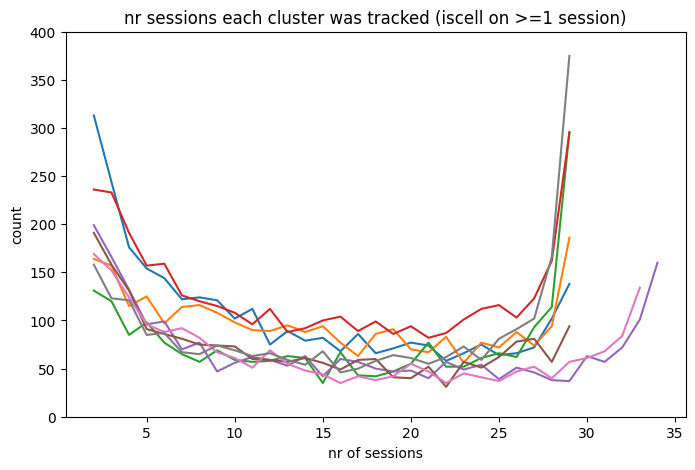

Nr of clusters tracked on all sessions: 1678/20574


In [26]:
fig, ax = plt.subplots(figsize=(8,5))
n_allSess = 0
n_tot = 0
for ii,fov_id in enumerate(fov_names):

    fov_name = 'FOV_'+fov_id
    results = roicat.helpers.pickle_load(
        filepath=str(dir_save / (fov_name + '.ROICaT.tracking.results' + '.pkl')),
        zipCompressed=False,
    )

    #load iscell arrays
    paths_allStat = results['input_data']['paths_stat']
    paths_allIscell = list(np.unique([(Path(path) / '..' / 'iscell.npy').resolve() for path in paths_allStat]))
    iscell_byS = [np.load(path)[:,0] for path in paths_allIscell]
    iscell_all = np.concatenate(iscell_byS)

    #find unique cluster labels for which iscell=True (on at least one day)
    labels_all = np.array(results['clusters']['labels'])
    labels_all_iscell = labels_all[np.bool(iscell_all)]
    unique_labels_iscell = np.unique(labels_all_iscell)

    #get counts of each label for which iscell=True (on at least one day)
    unique_labels, counts = np.unique(results['clusters']['labels'], return_counts=True)
    counts_iscell = counts[np.isin(unique_labels, unique_labels_iscell)]
    _ , nsessions_hist = np.unique(counts_iscell[1:], return_counts=True)

    #plot as a proportion of total
    ax.plot(np.arange(2,results['ROIs']['n_sessions']+1),nsessions_hist)

    n_allSess += nsessions_hist[-1]
    n_tot += len(counts_iscell[1:])
    
ax.set_ylim([0,400])
ax.set_xlabel('nr of sessions'), plt.ylabel('count');
ax.set_title('nr sessions each cluster was tracked (iscell on >=1 session)')

plt.show()
print('Nr of clusters tracked on all sessions: '+str(n_allSess)+'/'+str(n_tot))
#ff = Path('C:/Users/Samuel/Documents/2PI/'+subject+'/chronic').resolve()
#ff = Path('G:/Shared drives/WG-Mesoscope/Chronic/'+subject).resolve()
#ff = (Path(dir_Subject) / 'Chronic').resolve()
fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_clusterCounts_iscell' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / 'figures' / ('AllFOVs' + '_clusterCounts_iscell' + '.png'),bbox_inches='tight')

### Illustration for example FOV

In [27]:
fov_name = 'FOV_04'

results = roicat.helpers.pickle_load(
    filepath=str(dir_save / (fov_name + '.ROICaT.tracking.results' + '.pkl')),
    zipCompressed=False,
)

#load iscell arrays 
paths_allStat = results['input_data']['paths_stat']
paths_allIscell = list(np.unique([(Path(path) / '..' / 'iscell.npy').resolve() for path in paths_allStat]))
iscell_byS = [np.load(path)[:,0] for path in paths_allIscell]
iscell_all = np.concatenate(iscell_byS)

In [28]:
roicat.helpers.matlab_save(
    obj=results,
    filepath=dir_save / (name_save + '.ROICaT.tracking.results.mat'),
)

NameError: name 'name_save' is not defined

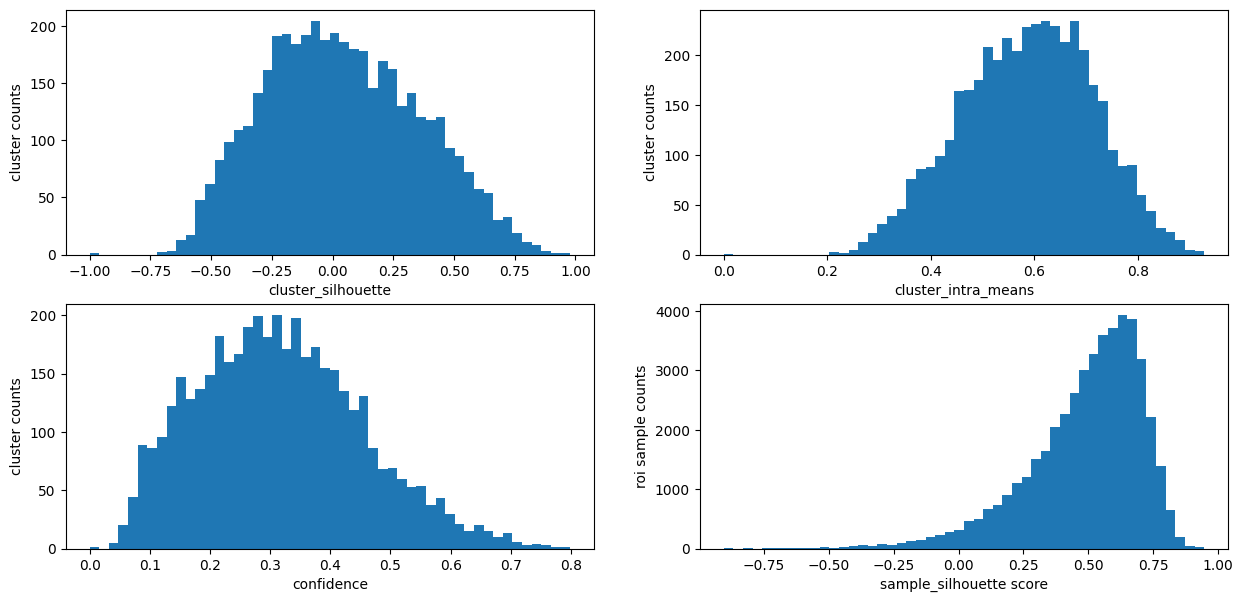

In [66]:
## Plot the distribution of the quality metrics
#confidence = (((results['quality_metrics']['cluster_silhouette'] + 1) / 2) * results['quality_metrics']['cluster_intra_means'])
confidence = (((np.array(results['quality_metrics']['cluster_silhouette']) + 1) / 2) * np.array(results['quality_metrics']['cluster_intra_means']))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

axs[0,0].hist(results['quality_metrics']['cluster_silhouette'], 50);
axs[0,0].set_xlabel('cluster_silhouette');
axs[0,0].set_ylabel('cluster counts');

axs[0,1].hist(results['quality_metrics']['cluster_intra_means'], 50);
axs[0,1].set_xlabel('cluster_intra_means');
axs[0,1].set_ylabel('cluster counts');

axs[1,0].hist(confidence, 50);
axs[1,0].set_xlabel('confidence');
axs[1,0].set_ylabel('cluster counts');

#axs[1,1].hist(results['quality_metrics']['sample_silhouette'], 50);
axs[1,1].hist(np.array(results['quality_metrics']['sample_silhouette'])[np.array(results['clusters']['labels'])!=-1], 50);
axs[1,1].set_xlabel('sample_silhouette score');
axs[1,1].set_ylabel('roi sample counts');

#fig.savefig(dir_save / (fov_name + '_QualityMetrics' + '.svg'),bbox_inches='tight')
#fig.savefig(dir_save / (fov_name + '_QualityMetrics' + '.png'),bbox_inches='tight')

In [67]:
labels = [c*t - (np.logical_not(c)) for c,t in zip(results_classification['preds'], results['clusters']['labels_bySession'])] if use_classificationResults else results['clusters']['labels_bySession']

FOVs_colored = roicat.visualization.compute_colored_FOV(
    labels = results['clusters']['labels'],
    spatialFootprints = results['ROIs']['ROIs_aligned'], 
    FOV_height = results['ROIs']['frame_height'], 
    FOV_width = results['ROIs']['frame_width'], 
    #alphas_sf = (np.array(results['quality_metrics']['sample_silhouette']) > 0), ## SET INCLUSION CRITERIA FOR ROI SAMPLES
    alphas_sf = (np.array([counts[num] == len(results['input_data']['paths_stat']) for num in results['clusters']['labels']])),
    #alphas_labels = (np.array(results['quality_metrics']['cluster_silhouette']) > 0) * (np.array(results['quality_metrics']['cluster_intra_means']) > 0),   ## SET INCLUSION CRITERIA FOR CLUSTERS/LABELS
    alphas_labels = confidence>0.5,   ## SET INCLUSION CRITERIA FOR CLUSTERS/LABELS
)

roicat.visualization.display_toggle_image_stack(FOVs_colored, image_size=2)

IndexError: index 3695 is out of bounds for axis 0 with size 3549

In [ ]:
FOV_clusters = roicat.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(1.0) for r in results['ROIs']['ROIs_aligned']],  ## Spatial footprint sparse arrays
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    labels=results["clusters"]["labels_bySession"],  ## cluster labels
#     labels=(np.array(results["clusters"]["labels"])!=-1).astype(np.int64),  ## cluster labels
    # alphas_labels=confidence*1.5,  ## Set brightness of each cluster based on some 1-D array
#     alphas_labels=(clusterer.quality_metrics['cluster_silhouette'] > 0) * (clusterer.quality_metrics['cluster_intra_means'] > 0.4),
#     alphas_sf=clusterer.quality_metrics['sample_silhouette'],  ## Set brightness of each ROI based on some 1-D array
)

roicat.visualization.display_toggle_image_stack(
    FOV_clusters, 
    image_size=1.5,
#     clim=[0,1.0],
)

In [ ]:
from collections import Counter

def mask_ucids_notTrackedEachDay(labels_by_session):
    n_sessions = len(labels_by_session)

    # Step 1: Count in how many sessions each UCID appears
    session_sets = [set(session_labels) for session_labels in labels_by_session]
    
    # Count occurrences of each UCID across sessions
    ucid_counter = Counter()
    for s in session_sets:
        ucid_counter.update(s)
    
    # Step 2: Identify UCIDs that appear in *all* sessions
    complete_ucids = {ucid for ucid, count in ucid_counter.items() if count >= 0.8*n_sessions}
    
    # Step 3: Replace UCIDs not in `complete_ucids` with -1
    masked_labels_by_session = [
        np.where(np.isin(session_labels, list(complete_ucids)), session_labels, -1)
        for session_labels in labels_by_session
    ]
    
    return masked_labels_by_session

def mask_ucids(labels_by_session,good_ucids):
    
    #Replace UCIDs not in `good_ucids` with -1
    masked_labels_by_session = [
        np.where(np.isin(session_labels, list(good_ucids)), session_labels, -1)
        for session_labels in labels_by_session
    ]
    
    return masked_labels_by_session

In [ ]:
FOV_clusters_trackedMostDays = roicat.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(1.0) for r in results['ROIs']['ROIs_aligned']],  ## Spatial footprint sparse arrays
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    labels=mask_ucids_notTrackedEachDay(results["clusters"]["labels_bySession"]),  ## cluster labels
#     labels=(np.array(results["clusters"]["labels"])!=-1).astype(np.int64),  ## cluster labels
    # alphas_labels=confidence*1.5,  ## Set brightness of each cluster based on some 1-D array
#     alphas_labels=(clusterer.quality_metrics['cluster_silhouette'] > 0) * (clusterer.quality_metrics['cluster_intra_means'] > 0.4),
#     alphas_sf=clusterer.quality_metrics['sample_silhouette'],  ## Set brightness of each ROI based on some 1-D array
)

roicat.visualization.display_toggle_image_stack(
    FOV_clusters_trackedMostDays, 
    image_size=1.5,
#     clim=[0,1.0],
)

In [ ]:
labels_iscell = np.array(results["clusters"]["labels_bySession"][0])[np.bool(iscell_byS[0])]
good_ucids = np.delete(labels_iscell, labels_iscell==-1)

FOV_clusters_trackedFromDay0 = roicat.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(1.0) for r in results['ROIs']['ROIs_aligned']],  ## Spatial footprint sparse arrays
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    labels=mask_ucids(results["clusters"]["labels_bySession"],good_ucids),  ## cluster labels
)

roicat.visualization.display_toggle_image_stack(
    FOV_clusters_trackedFromDay0, 
    image_size=1.5,
#     clim=[0,1.0],
)

In [ ]:
gif_name_save = name_save + '_clusters_cellsTrackedFromDay0.gif'
roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[(f * 255).astype(np.uint8) for f in FOV_clusters_trackedFromDay0], 
        text=[[f"{ii}",] for ii in range(len(FOV_clusters))], 
        font_size=1,
        line_width=2,
        position=(10, 30),
    ), 
    path=str(Path(dir_save).resolve() / gif_name_save),
    frameRate=2.0,
    loop=0,
)

In [ ]:
gif_name_save = name_save + '_clusters_allDs_hiConfidence.gif'
roicat.helpers.save_gif(
    array=roicat.helpers.add_text_to_images(
        images=[(f * 255).astype(np.uint8) for f in FOVs_colored], 
        text=[[f"{ii}",] for ii in range(len(FOVs_colored))], 
        font_size=1,
        line_width=2,
        position=(10, 30),
    ), 
    path=str(Path(dir_save).resolve() / gif_name_save),
    frameRate=2.0,
    loop=0,
)

In [ ]:
#load iscell arrays 
from pathlib import Path
paths_allStat = results['input_data']['paths_stat']
paths_allIscell = list(np.unique([(Path(path) / '..' / 'iscell.npy').resolve() for path in paths_allStat]))
iscell_byS = [np.load(path)[:,0] for path in paths_allIscell]
iscell_all = np.concatenate(iscell_byS)

In [ ]:
#select clusters to plot
ucids = np.array(results['clusters']['labels'])
ucids_unique, ucids_inv, ucids_counts = np.unique(ucids[ucids>=0], return_inverse=True, return_counts=True)

In [ ]:
#select clusters to plot
ucids = np.array(results['clusters']['labels'])
ucids_unique, ucids_inv, ucids_counts = np.unique(ucids[ucids>=0], return_inverse=True, return_counts=True)

ucids_num_iscell = np.array([sum(iscell_all[ucids>=0][ucids_inv==i]) for i in ucids_unique])
#ucids_qc = results['quality_metrics']['cluster_silhouette'][1:] #all except the '-1' cluster
ucids_qc = confidence[1:]

#cluster selection criteria: 
#1) TAKEN OUT: cluster should be present in at least half of all sessions
#2) cluster should be classified as a cell in at least half the sessions where it appears
#3) cluster confidence score should be at least 0.2
#idx_sel = (ucids_counts>=len(results['clusters']['labels_bySession'])*0.5) * (ucids_num_iscell>=ucids_counts*0.5) * (confidence[1:]>=0)
idx_sel = (ucids_num_iscell>=ucids_counts*0.5) * (confidence[1:]>=0)

ucids_unique = ucids_unique[idx_sel]
ucids_counts = ucids_counts[idx_sel]
ucids_num_iscell = ucids_num_iscell[idx_sel]
ucids_qc = ucids_qc[idx_sel]

#sorting critera
#ucids_unique = ucids_unique[np.argsort(-ucids_counts)] #sort by nr of days
ucids_unique = ucids_unique[np.argsort(-ucids_qc)] #sort by qc


print(f'Total number of clusters: {len(np.unique(results["clusters"]["labels"]))-1}')
print(f'Number of clusters selected: {len(ucids_unique)}')

In [ ]:
## Plot the distribution of the quality metrics after selection
confidence = (((np.array(results['quality_metrics']['cluster_silhouette']) + 1) / 2) * np.array(results['quality_metrics']['cluster_intra_means']))
#confidence = (((results['quality_metrics']['cluster_silhouette'] + 1) / 2) * results['quality_metrics']['cluster_intra_means'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

axs[0,0].hist(np.array(results['quality_metrics']['cluster_silhouette'])[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)], np.linspace(-1,1,51));
axs[0,0].set_xlabel('cluster_silhouette');
axs[0,0].set_ylabel('cluster counts');

axs[0,1].hist(np.array(results['quality_metrics']['cluster_intra_means'])[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)], np.linspace(0,1,51));
axs[0,1].set_xlabel('cluster_intra_means');
axs[0,1].set_ylabel('cluster counts');

axs[1,0].hist(confidence[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)], np.linspace(0,1,51));
axs[1,0].set_xlabel('confidence');
axs[1,0].set_ylabel('cluster counts');

#axs[1,1].hist(results['quality_metrics']['sample_silhouette'], 50);
axs[1,1].hist(np.array(results['quality_metrics']['sample_silhouette'])[np.isin(results['clusters']['labels'],ucids_unique)], np.linspace(-1,1,51));
axs[1,1].set_xlabel('sample_silhouette score');
axs[1,1].set_ylabel('roi sample counts');

fig.savefig(dir_save / (fov_name + '_sel_QualityMetrics' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_sel_QualityMetrics' + '.png'),bbox_inches='tight')

In [ ]:
# check for relationships between various quality metrics
#fig = plt.figure(figsize=(4,3))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)

im1 = axs[0].scatter(np.array(results['quality_metrics']['cluster_intra_means'])[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],
                 np.array(results['quality_metrics']['cluster_silhouette'])[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],10, c=ucids_counts, alpha=0.5);
axs[0].set_xlabel('cluster_intra_means');
axs[0].set_ylabel('cluster_silhouette');
axs[0].set_xlim(0,1)
axs[0].set_ylim(-1,1)

fig.colorbar(im1, ax=axs[0], ticks=np.linspace(min(ucids_counts),max(ucids_counts),5).astype(int), label='nr of sessions')

im2 = axs[1].scatter(np.array(results['quality_metrics']['cluster_intra_means'])[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],
                 np.array(results['quality_metrics']['cluster_silhouette'])[np.isin(results['quality_metrics']['cluster_labels_unique'],ucids_unique)],10, c=(ucids_num_iscell/ucids_counts), alpha=0.5, cmap='plasma');
axs[1].set_xlabel('cluster_intra_means');
#axs[1].set_ylabel('cluster_silhouette');
axs[1].set_xlim(0,1)
axs[1].set_ylim(-1,1)

fig.colorbar(im2, ax=axs[1], label='prop. classified as cell')


plt.show()

fig.savefig(dir_save / (fov_name + '_all_QualityMetrics_scatter' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_all_QualityMetrics_scatter' + '.png'),bbox_inches='tight')

In [ ]:
def crop_cluster_im_square(im: np.ndarray, center: np.ndarray, sz: int=25) -> np.ndarray:
    """
    Crops the image to a square of fixed size, centered around its center-of-mass. 
    SP 2024

    Args:
        im (np.ndarray):  
            Image to crop. (shape: *(H, W)*) 
        center (np.ndarray):
            center coords y, x (shape: (2))
        sz (int):
            width/height of square in pixels

    Returns:
        (np.ndarray): 
            im_out (np.ndarray): 
                Cropped image. (shape: *(sz, sz)*) 
    """
    from scipy.ndimage import center_of_mass

    if sz % 2 == 0:
        sz_odd = sz-1
    else:
        sz_odd = sz

    if np.all(np.isnan(im)) or np.all(im==0):
        im_out = np.zeros((sz,sz))
    else:
        com_y = center[0]
        com_x = center[1]
        # Define edges of cropping square
        y_min = max(0, int(com_y) - (sz_odd+1) // 2)
        x_min = max(0, int(com_x) - (sz_odd+1) // 2)
        y_max = min(im.shape[0], int(com_y) + (sz_odd+1) // 2)
        x_max = min(im.shape[1], int(com_x) + (sz_odd+1) // 2)
        # Crop the image
        im_out = im[y_min:y_max, x_min:x_max]

    # If the cropped region is smaller than the requested size, pad it
    pad_y = sz - im_out.shape[0]
    pad_x = sz - im_out.shape[1]
    #print(pad_y)
    #print(pad_x)
    #if pad_y > 0 or pad_x > 0:
    #    im_out = np.pad(im_out, ((pad_y,0), (pad_x,0)), mode='constant', constant_values=0)

    return im_out


In [ ]:
sampleSilhouette_bySession = []
cnt = 0
for i in np.arange(len(results['clusters']['labels_bySession'])):
    sampleSilhouette_bySession.append(np.array(results['quality_metrics']['sample_silhouette'])[cnt+np.arange(len(results['clusters']['labels_bySession'][i]))])
    cnt += len(results['clusters']['labels_bySession'][i])

In [ ]:
len(confidence)

In [ ]:
len(sampleSilhouette_bySession)

In [ ]:
#plot ucids_unique using Samuel's visualization method (grid with cropped mean images and masks)

from scipy.ndimage import center_of_mass
from matplotlib import colormaps
from matplotlib.colors import Normalize

n_labels_to_display = 12

suff = '_conf' #for saving the figures

add_all_masks = False

#exclude_bySession = [~np.array(iscell, dtype=bool) for iscell in iscell_byS] #exclude the ROIs that are not classified as cells
exclude_bySession = [s<0.0 for s in sampleSilhouette_bySession] #exclude the ROIs that have small sample_silhouette scores

color_by_QC = True #if false, will instead color by inclusion/exclusion criteria above
qc_bySession = sampleSilhouette_bySession
qc_label = 'sample silhouette score' #for colorbar labelling
cmap = colormaps.get_cmap('RdYlBu_r')
vmin = -0.5
vmax = 1

norm = Normalize(vmin=vmin, vmax=vmax) #select the range of QC expected here

meanImgs = rundata['aligner']['ims_registered_nonrigid']
meanImgs_masks = [rois[np.array(labs)>-1].max(0).toarray().reshape(results['ROIs']['frame_height'], results['ROIs']['frame_height']) for (rois,labs) in zip(results['ROIs']['ROIs_aligned'],results['clusters']['labels_bySession'])]

ROI_ims_sparse = scipy.sparse.vstack(results['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()

labels_bool_t = scipy.sparse.vstack([scipy.sparse.csr_matrix(np.array(results['clusters']['labels'])==u) for u in ucids_unique]).tocsr()
labels_bool_t = labels_bool_t[:n_labels_to_display]

fig, axs = plt.subplots(n_labels_to_display,len(meanImgs),figsize=(len(meanImgs),n_labels_to_display))
for i,lab in enumerate(labels_bool_t):
    idx = lab.indices
    com_y, com_x = center_of_mass(np.array(ROI_ims_sparse[idx].mean(axis=0).reshape(results['ROIs']['frame_height'], results['ROIs']['frame_width'])))
    cnt = 0
    for j in np.arange(len(meanImgs)):
        mIm = crop_cluster_im_square(meanImgs[j],np.array([com_y, com_x]))
        mIm_mask = crop_cluster_im_square(meanImgs_masks[j],np.array([com_y, com_x]))
        mIm_mask_alpha = 0.5 * ((mIm_mask - mIm_mask.min()) / (mIm_mask.max() - mIm_mask.min())+1e-8)
        green_overlay = np.zeros((mIm_mask.shape[0], mIm_mask.shape[1], 4))  # RGBA image
        green_overlay[..., 1] = 1.0  # Green channel to maximum
        green_overlay[..., 3] = mIm_mask_alpha    
        axs[i,j].imshow(mIm, cmap='gray')
        if add_all_masks:
            axs[i,j].imshow(green_overlay)  #all other ROI masks
        col_overlay = np.zeros((mIm.shape[0], mIm.shape[1], 4))  # RGBA image
        if np.isin(ucids_unique[i],results['clusters']['labels_bySession'][j]):
            im = ROI_ims_sparse[idx[cnt]].toarray().reshape(results['ROIs']['frame_height'], results['ROIs']['frame_width'])
            im = crop_cluster_im_square(im,np.array([com_y, com_x]))
            im_alpha = 0.9 * ((im - im.min()) / (im.max() - im.min())+1e-8)
            if color_by_QC:
                col_overlay = np.full((mIm.shape[0], mIm.shape[1], 4),cmap(norm(qc_bySession[j][results['clusters']['labels_bySession'][j]==ucids_unique[i]])))
            else:
                if exclude_bySession[j][results['clusters']['labels_bySession'][j]==ucids_unique[i]]:
                    col_overlay[..., 2] = 1.0  # Blue channel to maximum if this was not classified as a cell
                else:
                    col_overlay[..., 0] = 1.0  # Red channel to maximum if this was classified as a cell
            col_overlay[..., 3] = im_alpha          
            cnt += 1
        im = axs[i,j].imshow(col_overlay) 
        #axs[i,j].imshow(im, cmap='gray')
        axs[i,j].axis("off")

fig.subplots_adjust(right=0.92)
dummy_ax = fig.add_axes([0.95, 0.1, 0.03, 0.7])
cbar_im = plt.imshow(np.array([[0,1]]), cmap=cmap)
plt.gca().set_visible(False)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar = plt.colorbar(orientation="vertical", cax = cbar_ax, ticks=[0,1], label=qc_label)
cbar_ax.set_yticklabels([vmin, vmax]);

fig.savefig(dir_save / 'figures' / (fov_name + '_clustersBySession' + suff + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / 'figures' / (fov_name + '_clustersBySession' + suff + '.png'),bbox_inches='tight')

In [ ]:
#plot example ucids using Samuel's visualization method (grid with cropped mean images and masks)

from scipy.ndimage import center_of_mass
from matplotlib import colormaps
from matplotlib.colors import Normalize

example_ids = np.array([675, 658])
n_labels_to_display = len(example_ids)

add_all_masks = False

#exclude_bySession = [~np.array(iscell, dtype=bool) for iscell in iscell_byS] #exclude the ROIs that are not classified as cells
exclude_bySession = [s<0.0 for s in sampleSilhouette_bySession] #exclude the ROIs that have small sample_silhouette scores

color_by_QC = False #if false, will instead color by inclusion/exclusion criteria above
qc_bySession = sampleSilhouette_bySession
qc_label = 'sample silhouette score' #for colorbar labelling
cmap = colormaps.get_cmap('RdYlBu_r')
vmin = -0.5
vmax = 1

norm = Normalize(vmin=vmin, vmax=vmax) #select the range of QC expected here

meanImgs = rundata['aligner']['ims_registered_nonrigid']
meanImgs_masks = [rois[np.array(labs)>-1].max(0).toarray().reshape(results['ROIs']['frame_height'], results['ROIs']['frame_height']) for (rois,labs) in zip(results['ROIs']['ROIs_aligned'],results['clusters']['labels_bySession'])]

ROI_ims_sparse = scipy.sparse.vstack(results['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()

labels_bool_t = scipy.sparse.vstack([scipy.sparse.csr_matrix(np.array(results['clusters']['labels'])==u) for u in example_ids]).tocsr()
#labels_bool_t = labels_bool_t[:n_labels_to_display]

fig, axs = plt.subplots(n_labels_to_display,len(meanImgs),figsize=(len(meanImgs),n_labels_to_display))
for i,lab in enumerate(labels_bool_t):
    idx = lab.indices
    com_y, com_x = center_of_mass(np.array(ROI_ims_sparse[idx].mean(axis=0).reshape(results['ROIs']['frame_height'], results['ROIs']['frame_width'])))
    cnt = 0
    for j in np.arange(len(meanImgs)):
        mIm = crop_cluster_im_square(meanImgs[j],np.array([com_y, com_x]))
        mIm_mask = crop_cluster_im_square(meanImgs_masks[j],np.array([com_y, com_x]))
        mIm_mask_alpha = 0.5 * ((mIm_mask - mIm_mask.min()) / (mIm_mask.max() - mIm_mask.min())+1e-8)
        green_overlay = np.zeros((mIm_mask.shape[0], mIm_mask.shape[1], 4))  # RGBA image
        green_overlay[..., 1] = 1.0  # Green channel to maximum
        green_overlay[..., 3] = mIm_mask_alpha    
        axs[i,j].imshow(mIm, cmap='gray')
        if add_all_masks:
            axs[i,j].imshow(green_overlay)  #all other ROI masks
        col_overlay = np.zeros((mIm.shape[0], mIm.shape[1], 4))  # RGBA image
        if np.isin(example_ids[i],results['clusters']['labels_bySession'][j]):
            im = ROI_ims_sparse[idx[cnt]].toarray().reshape(results['ROIs']['frame_height'], results['ROIs']['frame_width'])
            im = crop_cluster_im_square(im,np.array([com_y, com_x]))
            im_alpha = 0.9 * ((im - im.min()) / (im.max() - im.min())+1e-8)
            if color_by_QC:
                col_overlay = np.full((mIm.shape[0], mIm.shape[1], 4),cmap(norm(qc_bySession[j][results['clusters']['labels_bySession'][j]==example_ids[i]])))
            else:
                if exclude_bySession[j][results['clusters']['labels_bySession'][j]==example_ids[i]]:
                    col_overlay[..., 2] = 1.0  # Blue channel to maximum if this was not classified as a cell
                else:
                    col_overlay[..., 0] = 1.0  # Red channel to maximum if this was classified as a cell
            col_overlay[..., 3] = im_alpha          
            cnt += 1
        im = axs[i,j].imshow(col_overlay) 
        #axs[i,j].imshow(im, cmap='gray')
        axs[i,j].axis("off")

fig.savefig(dir_save / (fov_name + '_exampleClustersBySession' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_exampleClustersBySession' + '.png'),bbox_inches='tight')

In [ ]:
#plot example_ids using roicat's standard vizualization

ROI_ims_sparse = scipy.sparse.vstack(results['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()

ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(roicat.visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), results['ROIs']['frame_height'], results['ROIs']['frame_width']))), axis=1) )

for ii in range(min(len(ucid_sfCat), 12)):
    plt.figure(figsize=(40,1))
    plt.imshow(ucid_sfCat[ii], cmap='gray')
    plt.axis('off')

In [ ]:
#plot the full matrix of clusters-by-day, color coded by QC
qc_bySession = sampleSilhouette_bySession
qc_label = 'sample silhouette score' #for colorbar labelling
cmap = colormaps.get_cmap('RdYlBu_r')
cmap.set_bad('gray')

suff = '_ss'

#vmin = -0.5
#vmax = 1

qc_fullMat = np.empty((len(ucids_unique),len(meanImgs)))
qc_fullMat[:] = np.nan
lbS = results['clusters']['labels_bySession']

for i, ucid in enumerate(ucids_unique):
    for j, labs in enumerate(lbS):
        if np.isin(ucid,labs):
            qc_fullMat[i,j] = qc_bySession[j][labs==ucid]

fig = plt.figure(figsize=(3,25))
plt.imshow(qc_fullMat, interpolation=None, aspect='auto', cmap = cmap, vmin=vmin, vmax=vmax) 
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

fig.savefig(dir_save / (fov_name + '_clusterMatrix' + suff + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_clusterMatrix' + suff + '.png'),bbox_inches='tight')

In [ ]:
# %matplotlib widget

ucids = np.array(results['clusters']['labels'])
_, counts = np.unique(ucids, return_counts=True)

n_sessions = len(results['clusters']['labels_bySession'])
fig = plt.figure(figsize=(6,3))
plt.hist(counts, bins=n_sessions*2 + 1, range=(0, n_sessions+1));

plt.xlabel('count (n sessions)');
plt.ylabel('nr of clusters');
plt.title('cluster counts (selection)');

fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.png'),bbox_inches='tight')

In [ ]:
ucids = np.array(results['clusters']['labels'])
_, counts_sel = np.unique(ucids[np.isin(ucids,ucids_unique)], return_counts=True)

n_sessions = len(results['clusters']['labels_bySession'])
fig = plt.figure(figsize=(6,3))
plt.hist(counts_sel, bins=n_sessions*2 + 1, range=(0, n_sessions+1));

plt.xlabel('count (n sessions)')
plt.ylabel('nr of clusters')
plt.title('cluster counts (selection)');

fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_clusterCounts' + '.png'),bbox_inches='tight')

In [ ]:
suff = '_iscell'

ucids = np.array(results['clusters']['labels'])
lbS = results['clusters']['labels_bySession']
n_sessions = len(lbS)

nClusters_perSession = [np.sum((np.array(l)>-1) * (np.array(iscell,dtype='bool'))) for l,iscell in zip(lbS,iscell_byS)]
fig = plt.figure(figsize=(6,3))
#plt.bar(np.arange(n_sessions),nClusters_perSession, color='gray', alpha=0.5)
plt.bar(np.arange(n_sessions),[sum(c) for c in iscell_byS], color='gray', alpha=0.5)

plt.ylabel('nr of clusters')
plt.xlabel('session')
plt.title('N cells per session (iscell=True)');

colors = plt.cm.jet(np.linspace(0,1,len(lbS)))
#fig2 = plt.figure(figsize=(6,3))
for i, labs in enumerate(lbS):
    #ucids_thisSession = labs[np.isin(labs,np.unique(ucids[ucids>=0])) * np.array(iscell_byS[i],dtype='bool')]
    ucids_thisSession = np.array(labs)[np.array(iscell_byS[i],dtype='bool')]
    #plt.plot(np.arange(len(lbS)),[np.sum(np.isin(l,ucids_thisSession)) for l in lbS], color=colors[i], alpha=0.5)
    numPerSess = [np.sum(np.isin(l,ucids_thisSession[ucids_thisSession>=0])) for l in lbS]
    numPerSess[i] = sum(iscell_byS[i])
    plt.plot(np.arange(len(lbS)),numPerSess, color=colors[i], alpha=0.5)
plt.show()

fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.svg'),bbox_inches='tight')
fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.png'),bbox_inches='tight')

In [ ]:
#select clusters to plot
#ucids = np.array(results['clusters']['labels'])
#ucids_unique, ucids_inv, ucids_counts = np.unique(ucids[ucids>=0], return_inverse=True, return_counts=True)

#ucids_num_iscell = np.array([sum(iscell_all[ucids>=0][ucids_inv==i]) for i in ucids_unique])
#ucids_qc = results['quality_metrics']['cluster_silhouette'][1:] #all except the '-1' cluster
#ucids_qc = confidence[1:]

#selection criteria
#idx_sel = (ucids_counts>=12) * (ucids_num_iscell>=12) #* (ucids_qc<0.5)

#ucids_unique = ucids_unique[idx_sel]

lbS = results['clusters']['labels_bySession']
n_sessions = len(lbS)

suff = '_sel'

nClusters_perSession = [np.sum(np.isin(l,ucids_unique)) for l in lbS]
fig = plt.figure(figsize=(6,3))
plt.bar(np.arange(n_sessions),nClusters_perSession, color='gray', alpha=0.5)

plt.ylabel('nr of clusters')
plt.xlabel('session')
plt.title("N clusters per session  (n="+str(len(ucids_unique))+")");

colors = plt.cm.jet(np.linspace(0,1,len(lbS)))
#fig2 = plt.figure(figsize=(6,3))
for i, labs in enumerate(lbS):
    ucids_thisSession = np.array(labs)[np.isin(labs,ucids_unique)]
    plt.plot(np.arange(len(lbS)),[np.sum(np.isin(l,ucids_thisSession)) for l in lbS], color=colors[i], alpha=0.5)

plt.show()

#fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.svg'),bbox_inches='tight')
#fig.savefig(dir_save / (fov_name + '_nClusters_perSession' + suff + '.png'),bbox_inches='tight')

In [ ]:
len(ucids_unique)

In [ ]:
#plot showing the average proportion of clusters shared before and after a given day
import scipy.stats as st

suff = '_sel'

propShared_aroundSess = np.empty((len(lbS),2*len(lbS)-1))
propShared_aroundSess[:] = np.nan
iMid = len(lbS)-1

for i, labs in enumerate(lbS):
    ucids_thisSession = np.array(labs)[np.isin(labs,ucids_unique)]
    vals = np.array([np.sum(np.isin(l,ucids_thisSession)) for l in lbS])/len(ucids_thisSession)
    propShared_aroundSess[i,len(lbS)-i-1+np.arange(len(lbS))] = vals

data = propShared_aroundSess
x = np.arange(-len(lbS)+1,len(lbS))
y = np.nanmean(propShared_aroundSess,axis=0)
err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')
#[l,u] = st.t.interval(0.90, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
cutoff = 5

#plt.ylim(0,520)
plt.figure(figsize=(6,3))
plt.errorbar(x[cutoff:-cutoff], y[cutoff:-cutoff], yerr=err[cutoff:-cutoff], fmt='-o')
plt.xlabel('session diff')
plt.ylabel('prop. tracked')
plt.title("tracked clusters across sessions (n="+str(len(ucids_unique))+")")
plt.gca().set_ylim(0.52, 1.03)

plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.svg'),bbox_inches='tight')
plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.png'),bbox_inches='tight')

In [ ]:
#plot showing the average proportion of clusters shared before and after a given day (only for ROIs with iscell=True)
import scipy.stats as st

suff = '_iscell'

ucids = np.array(results['clusters']['labels'])
lbS = results['clusters']['labels_bySession']

propShared_aroundSess = np.empty((len(lbS),2*len(lbS)-1))
propShared_aroundSess[:] = np.nan
iMid = len(lbS)-1

for i, labs in enumerate(lbS):
    #ucids_thisSession = labs[np.isin(labs,np.unique(ucids[ucids>=0])) * np.array(iscell_byS[i],dtype='bool')]
    ucids_thisSession = np.array(labs)[np.array(iscell_byS[i],dtype='bool')]
    vals = np.array([np.sum(np.isin(l,ucids_thisSession[ucids_thisSession>=0])) for l in lbS])/len(ucids_thisSession)
    vals[i] = 1 #make sure ref value is 1
    propShared_aroundSess[i,len(lbS)-i-1+np.arange(len(lbS))] = vals

data = propShared_aroundSess
x = np.arange(-len(lbS)+1,len(lbS))
y = np.nanmean(propShared_aroundSess,axis=0)
err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')
#[l,u] = st.t.interval(0.90, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
cutoff = 5

#plt.ylim(0,520)
plt.figure(figsize=(6,3))
plt.errorbar(x[cutoff:-cutoff], y[cutoff:-cutoff], yerr=err[cutoff:-cutoff], fmt='-o')
plt.xlabel('session diff')
plt.ylabel('prop. tracked')
plt.title("Proportion of tracked cells (iscell = True)");

plt.gcf().savefig(dir_save / (fov_name + '_propCells_tracked' + suff + '.svg'),bbox_inches='tight')
plt.gcf().savefig(dir_save / (fov_name + '_propCells_tracked' + suff + '.png'),bbox_inches='tight')

In [ ]:
img = np.load(Path('Y:/Subjects/SP060/2024-07-11/001/alf/FOV_00') / Path('mpciMeanImage.images.npy'))

In [ ]:
#plot showing the average proportion of clusters shared before and after a given day, separated by cluster QM
import scipy.stats as st

uniqueLabels = np.unique(np.array(results['clusters']['labels']))
uniqueLabels = uniqueLabels[uniqueLabels>=0]
qc_perLabel = (((np.array(results['quality_metrics']['cluster_silhouette']) + 1) / 2) * results['quality_metrics']['cluster_intra_means']) #confidence
#qc_perLabel = results['quality_metrics']['cluster_silhouette']
qc_perLabel = qc_perLabel[1:] 

uniqueLabels = ucids_unique
qc_perLabel = ucids_qc

suff = '_sel_qc'

plt.figure(figsize=(6,3))
import math
qm_mins = np.arange(math.floor(min(qc_perLabel) * 10)/10.0,math.ceil(max(qc_perLabel) * 10)/10.0,0.2)
qm_maxs = qm_mins+0.2
colors = plt.cm.coolwarm(np.linspace(0,1,len(qm_mins)))
cnt = 0

for qmin, qmax in zip(qm_mins,qm_maxs):
    
    propShared_aroundSess = np.empty((len(lbS),2*len(lbS)-1))
    propShared_aroundSess[:] = np.nan
    iMid = len(lbS)-1
    
    for i, labs in enumerate(lbS):
        ucids_thisSession = np.array(labs)[np.isin(labs,uniqueLabels[(qc_perLabel>qmin)*(qc_perLabel<=qmax)])]
        vals = np.array([np.sum(np.isin(l,ucids_thisSession)) for l in lbS])/len(ucids_thisSession)
        propShared_aroundSess[i,len(lbS)-i-1+np.arange(len(lbS))] = vals
    
    data = propShared_aroundSess
    cutoff = 5
    x = np.arange(-len(lbS)+1,len(lbS))
    y = np.nanmean(propShared_aroundSess,axis=0)
    #err = st.sem(propShared_aroundSess,axis=0,nan_policy='omit')
    #[l,u] = st.t.interval(0.90, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    
    #plt.ylim(0,520)
    
    #plt.errorbar(x[cutoff:-cutoff], y[cutoff:-cutoff], yerr=err[cutoff:-cutoff], fmt='-o')
    plt.plot(x[cutoff:-cutoff], y[cutoff:-cutoff], color=colors[cnt])
    if True:#cnt==0 or cnt==len(qm_mins)-1:
        plt.text(x[-cutoff], y[-cutoff-1], "{:.1f}".format(qmin)+"-"+"{:.1f}".format(qmax), color=colors[cnt])
    
    cnt += 1

plt.xlabel('session diff')
plt.ylabel('prop. tracked')
plt.gca().set_ylim(0.47,1.03)
plt.title("tracked clusters across sessions, divided by QM (selection)");

plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.svg'),bbox_inches='tight')
plt.gcf().savefig(dir_save / (fov_name + '_propClusters_tracked' + suff + '.png'),bbox_inches='tight')

### Playground

In [ ]:
masks_sparse

In [ ]:
from sklearn.preprocessing import normalize
spatialFootprints_norm = normalize(masks_sparse.toarray(), norm='l1', axis=0)

In [ ]:
import scipy
import pathlib as Path

masks_sparse = np.load('Y:/Subjects/SP060/2024-07-11/001/alf/FOV_00/mpciROIs.masks.sparse_npz')
#masks_sparse = scipy.sparse.load_npz('Y:/Subjects/SP060/2024-07-11/001/alf/FOV_00/mpciROIs.masks.sparse_npz')

In [ ]:
from one.api import One
one = One.setup(cache_dir='Y:/Subjects')

In [ ]:
from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')


In [ ]:
from one.api import One
masks = One.load_dataset('Y:/Subjects/SP060/2024-07-11/001/alf/FOV_00/mpciROIs.masks')

In [ ]:
from one.alf import io
masks = io.load_file_content('Y:/Subjects/SP060/2024-07-11/001/alf/FOV_00/mpciROIs.masks.sparse_npz')

In [ ]:
sparse_masks = masks.to_scipy_sparse

In [ ]:
sparse_mask_list = [m.to_scipy_sparse for m in masks]

In [ ]:
sparse_mask_list[0]

In [ ]:
import sparse
masks = sparse.load_npz(Path(r'Y:/Subjects/SP060/2024-07-11/001/alf/FOV_00/mpciROIs.masks.sparse_npz')).to_scipy_sparse


In [ ]:
masks

In [ ]:
eid = one.search(subject='SP058', date='2024-07-11')
print(eid)
fov_folders = one.list_collections(eid, collection='alf/FOV*')
fovs = sorted(map(lambda x: int(x[-2:]), fov_folders))
print(fovs)

one.load_dataset(eid, 'mpciROIs.masks.sparse_npz')

In [ ]:
one.search(subject='SP058', dataset='mpciROIs')

In [ ]:
ROIdata = one.load_dataset(eid, 'alf/FOV_00', object='mpciROIs')

In [ ]:
#eid = 'b1ca324f-5db7-4106-8be2-0dd9cce17648'
FOV = 0  # The field of view (FOV) to load
suite2p_zip = one.load_dataset(eid, '*ROIData.raw', collection=f'alf/FOV_{FOV:02}')

# Unarchive zip file
import shutil
dst_dir = suite2p_zip.parent.joinpath('suite2p_output')
files = shutil.unpack_archive(suite2p_zip, dst_dir)

# Run the suite2p GUI
import suite2p.gui
suite2p.gui.run(statfile=dst_dir / 'stat.npy')

In [ ]:
eids = one.search(subject='SP058', date_range=['2024-07-11','2024-07-12'])
masks = one.load_dataset(eids[0], 'mpciROIs.masks')

In [ ]:
masks = scipy.sparse.load_npz(masks_sparse)

In [ ]:
## List all available quality metrics
print('Available quality metrics:')
display(results['quality_metrics'])